# Ford GoBike System Data
## by Youssef Ali

## Preliminary Wrangling

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.
________________________________________________________

# Questions
I have some questions hat need answers, and this dataset will help me. The questions are:
+ When are most trips taken in terms of time of day, day of the week?
+ How long does the average trip take?
+ Does the above depend on if a user is a subscriber or customer?
+ What are the most interesting stations?
_______________________________

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [75]:
# Download and unzip our data
!curl https://s3.amazonaws.com/baywheels-data/202006-baywheels-tripdata.csv.zip -o data.zip && unzip data.zip

df = pd.read_csv('202006-baywheels-tripdata.csv')
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,08A4A9F7315901F3,electric_bike,2020-06-03 16:37:10,2020-06-03 16:48:28,NaN,NaN,NaN,NaN,37.770000,-122.40000,37.760000,-122.420000,casual
1,844F9D906468C441,electric_bike,2020-06-03 12:22:47,2020-06-03 12:44:02,NaN,NaN,NaN,NaN,37.780000,-122.49000,37.780000,-122.460000,casual
2,0E441BF8A86C544E,electric_bike,2020-06-02 17:37:43,2020-06-02 17:52:21,Powell St at Columbus Ave,487.0,NaN,NaN,37.800426,-122.41095,37.790000,-122.440000,casual
3,CAFE64864422F475,electric_bike,2020-06-02 18:13:01,2020-06-02 18:48:30,NaN,NaN,NaN,NaN,37.760000,-122.41000,37.770000,-122.430000,casual
4,172957A20160D568,electric_bike,2020-06-03 15:16:06,2020-06-03 16:06:10,Church St at Duboce Ave,85.0,48th Ave at Cabrillo St,521.0,37.769841,-122.42921,37.772894,-122.509079,casual


In [76]:
df.shape

(158168, 13)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158168 entries, 0 to 158167
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             158168 non-null  object 
 1   rideable_type       158168 non-null  object 
 2   started_at          158168 non-null  object 
 3   ended_at            158168 non-null  object 
 4   start_station_name  99220 non-null   object 
 5   start_station_id    99220 non-null   float64
 6   end_station_name    97151 non-null   object 
 7   end_station_id      97151 non-null   float64
 8   start_lat           158168 non-null  float64
 9   start_lng           158168 non-null  float64
 10  end_lat             157892 non-null  float64
 11  end_lng             157892 non-null  float64
 12  member_casual       158168 non-null  object 
dtypes: float64(6), object(7)
memory usage: 15.7+ MB


In [84]:
df.nunique()

ride_id               158168
rideable_type              2
started_at            149923
ended_at              149655
start_station_name       426
start_station_id         426
end_station_name         431
end_station_id           431
start_lat              41016
start_lng              42828
end_lat                41300
end_lng                42926
member_casual              2
dtype: int64

In [83]:
# Convert the object-type timestamps to datetime-type
df.started_at = pd.to_datetime(df.started_at)
df.ended_at = pd.to_datetime(df.ended_at)

### What is the structure of your dataset?

> It is look like we have 158168 records with 13 features. But we can summarize them in:
1. Ride ID
2. Bike type
3. Timestamp for start and end ride
4. Start/End position and distance
5. Member casual


### What is/are the main feature(s) of interest in your dataset?

> The mean features are Bike type, the timestamp, the start and end position and distance, member casual

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I will use all the main features to support my own conclusions

## Univariate Exploration

In [85]:
# Let's see what we have now
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,08A4A9F7315901F3,electric_bike,2020-06-03 16:37:10,2020-06-03 16:48:28,NaN,NaN,NaN,NaN,37.770000,-122.40000,37.760000,-122.420000,casual
1,844F9D906468C441,electric_bike,2020-06-03 12:22:47,2020-06-03 12:44:02,NaN,NaN,NaN,NaN,37.780000,-122.49000,37.780000,-122.460000,casual
2,0E441BF8A86C544E,electric_bike,2020-06-02 17:37:43,2020-06-02 17:52:21,Powell St at Columbus Ave,487.0,NaN,NaN,37.800426,-122.41095,37.790000,-122.440000,casual
3,CAFE64864422F475,electric_bike,2020-06-02 18:13:01,2020-06-02 18:48:30,NaN,NaN,NaN,NaN,37.760000,-122.41000,37.770000,-122.430000,casual
4,172957A20160D568,electric_bike,2020-06-03 15:16:06,2020-06-03 16:06:10,Church St at Duboce Ave,85.0,48th Ave at Cabrillo St,521.0,37.769841,-122.42921,37.772894,-122.509079,casual


I will calculate how much time each ride took

In [98]:
df['time'] = (df.ended_at - df.started_at).apply(lambda x: x.seconds)

I will calculate also the distance of each ride

In [99]:
def distance(x):
    """
    This function calculates the distance in kilometers between any two (latitude,longitude) points
    
    INPUT:
    x: tuple, list, or any groupping method (len = 4)
    OUTPUT:
    distance: The distance between those two points in kilometers
    """
    
    from math import atan2
    # approximate radius of earth in km
    R = 6373.0

    lat1, lon1, lat2, lon2 = np.radians(x)
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2*atan2(np.sqrt(a), np.sqrt(1-a))

    distance = R*c
    return distance

In [100]:
df['ride_distance'] = df[['start_lat','start_lng','end_lat','end_lng']].apply(distance, axis=1)

In [187]:
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,time,ride_distance
0,08A4A9F7315901F3,electric_bike,2020-06-03 16:37:10,2020-06-03 16:48:28,NaN,NaN,NaN,NaN,37.770000,-122.40000,37.760000,-122.420000,casual,678,2.080844
1,844F9D906468C441,electric_bike,2020-06-03 12:22:47,2020-06-03 12:44:02,NaN,NaN,NaN,NaN,37.780000,-122.49000,37.780000,-122.460000,casual,1275,2.637378
2,0E441BF8A86C544E,electric_bike,2020-06-02 17:37:43,2020-06-02 17:52:21,Powell St at Columbus Ave,487.0,NaN,NaN,37.800426,-122.41095,37.790000,-122.440000,casual,878,2.804341
3,CAFE64864422F475,electric_bike,2020-06-02 18:13:01,2020-06-02 18:48:30,NaN,NaN,NaN,NaN,37.760000,-122.41000,37.770000,-122.430000,casual,2129,2.080844
4,172957A20160D568,electric_bike,2020-06-03 15:16:06,2020-06-03 16:06:10,Church St at Duboce Ave,85.0,48th Ave at Cabrillo St,521.0,37.769841,-122.42921,37.772894,-122.509079,casual,3004,7.030530


In [382]:
df.dropna(subset=['time', 'ride_distance'],axis=0,inplace=True)
# filter all the records that have time per ride smaller than 10 seconds
df = df[df['time']>10]
# If the start station is the end station make the distance == 0
df.loc[df.start_station_name == df.end_station_name,'ride_distance'] = 0

In [384]:
df.time.describe()

count    156974.000000
mean       1241.781161
std        2471.595060
min          11.000000
25%         448.000000
50%         799.000000
75%        1402.000000
max       86399.000000
Name: time, dtype: float64

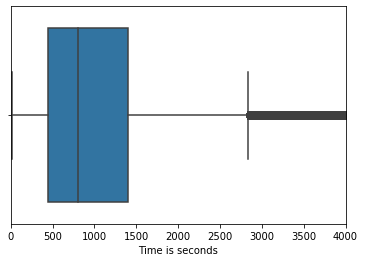

In [399]:
sb.boxplot(df.time)#.hist(bins=[10,23,45,100,100,230,450,1000,2300,4500,10000])
plt.xlim(0,4000)
plt.xlabel("Time is seconds");

I do not think that those are real outlieres. I generated this column by subtracting the starttime from the endtime and I think that these two columns are correct.<br>
The time vary from one to another, but the most times are from 7 to 25 minutes

#### What about the type of the bike?

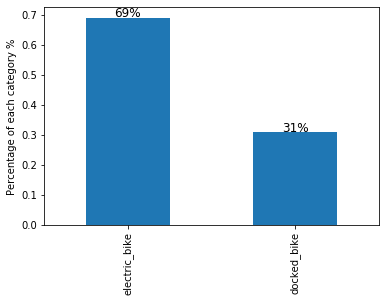

In [408]:
vcount = df.rideable_type.value_counts()
vcount.plot(kind='bar')
cration = vcount.max()/vcount.sum()
y = np.arange(0,cration+0.1, 0.1)
plt.yticks(y*vcount.sum(),y.round(2))
plt.ylabel("Percentage of each category %")
for i,v in enumerate(vcount):
    plt.text(i,v+400,str(int(round(v/vcount.sum(),2)*100))+'%', horizontalalignment='center', fontsize=12)
plt.show()

Most of the users prefer the electric bike over the docked one

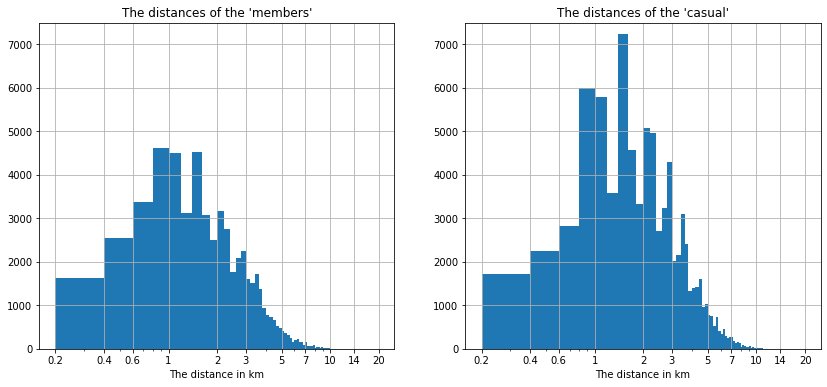

In [424]:
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
df.query("member_casual == 'member'").ride_distance.hist(bins=np.arange(0.2,20,0.2))
plt.xscale('log')
plt.xticks([0.2,0.4,0.6,1,2,3,5,7,10,14,20], [0.2,0.4,0.6,1,2,3,5,7,10,14,20])
plt.title("The distances of the 'members'")
plt.xlabel("The distance in km")
plt.ylim(0,7500)
plt.subplot(1,2,2)
df.query("member_casual == 'casual'").ride_distance.hist(bins=np.arange(0.2,20,0.2))
plt.xscale('log')
plt.xticks([0.2,0.4,0.6,1,2,3,5,7,10,14,20], [0.2,0.4,0.6,1,2,3,5,7,10,14,20])
plt.title("The distances of the 'casual'")
plt.xlabel("The distance in km")
plt.ylim(0,7500)
plt.show()

Most of the riders rode from 600m to 3km but the casual group seems to have more records in it. But let's check

#### What is the ratio between the guests and the members?

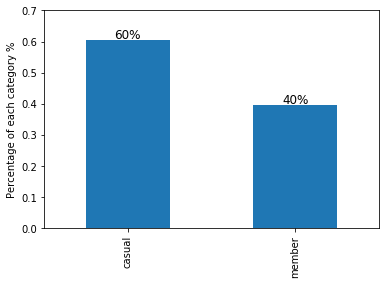

In [370]:
vcount = df.member_casual.value_counts()
vcount.plot(kind='bar')
cration = vcount.max()/vcount.sum()
y = np.arange(0,cration+0.1, 0.1)
plt.yticks(y*vcount.sum(),y.round(2))
plt.ylabel("Percentage of each category %")
for i,v in enumerate(vcount):
    plt.text(i,v+1000,str(int(round(v/vcount.sum(),2)*100))+'%', horizontalalignment='center', fontsize=12)
plt.show()

We were right. The casual groups is more than the members than 20%

In [180]:
df.started_at.min(), df.started_at.max()

(Timestamp('2020-06-01 00:02:16'), Timestamp('2020-06-30 23:59:48'))

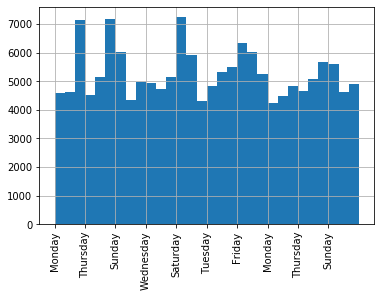

In [186]:
df.started_at.hist(bins=30)
ticks = pd.to_datetime(['2020-06-'+str(x) for x in range(1,31,3)])
weekdays = dict({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
days = [weekdays[i] for i in ticks.weekday]
plt.xticks(ticks,days,rotation=90);

### Ride Start Day
We have in this visualization a wavy distribution. The most frequent weekdays that people start to rent a bike are Friday, Satuday, and Sunday. And this is abviously seems correct; as these are the weekends were there is no work and every one goes to take a break.

We can see the hours of working

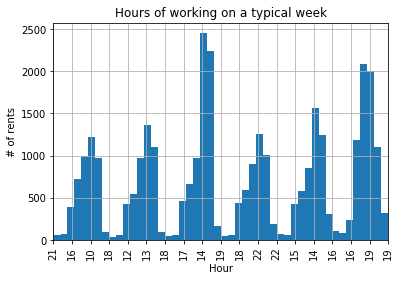

In [528]:
df.started_at.hist(bins=30*8)
ticks = pd.to_datetime(['2020-06-'+str(x)+' '+f'{v}:00:00' for v in ['08', '16', '00'] for x in np.arange(1,31,1)])
hours = [d.hour for d in df.started_at]
plt.xticks(ticks,hours,rotation=90)
plt.xlim(pd.to_datetime(['2020-06-01']), pd.to_datetime(['2020-06-7']))
plt.title("Hours of working on a typical week")
plt.xlabel("Hour")
plt.ylabel("# of rents")
plt.show()

it looks like the hours working that have most tips are in the afternoon and evening

What are the most station people start at?

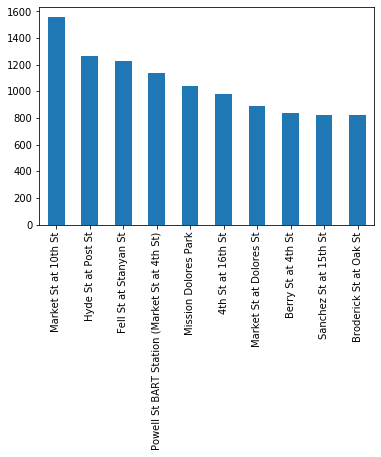

In [272]:
df.start_station_name.value_counts()[:10].plot(kind='bar')
_ = plt.xticks()[1];

We can conclude that the top 10 start station are:

In [303]:
for e in list(_):
    print(e.get_text()) 

Market St at 10th St
Hyde St at Post St
Fell St at Stanyan St
Powell St BART Station (Market St at 4th St)
Mission Dolores Park
4th St at 16th St
Market St at Dolores St
Berry St at 4th St
Sanchez St at 15th St
Broderick St at Oak St


This may has many reasons like the beuty of the place or they have better bikes or eve they make discounts.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The disrtibution of the startday is wavy, but the most rides are in weekends. I think it is reasonable as everyone are free to play and joy.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I changed the dtype of the start and end date to `datetime` type. I also made two new features `ride_distance` and `time`

## Bivariate Exploration


Let's see the numeric type data in our dataset

In [429]:
numeric_vars = ['time', 'ride_distance']

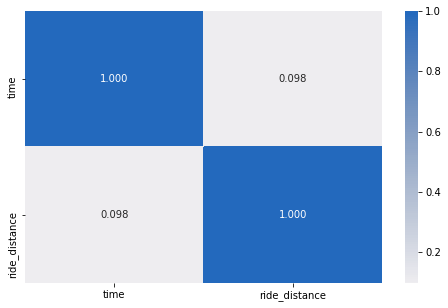

In [430]:
plt.figure(figsize = [8, 5])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

Make some grids

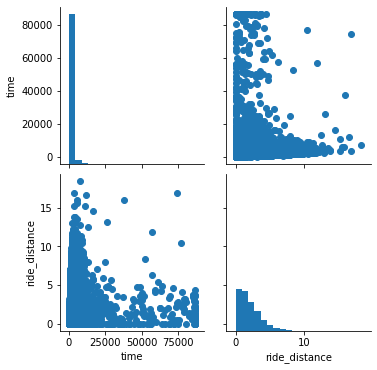

In [436]:
g = sb.PairGrid(data = df, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)
plt.show()

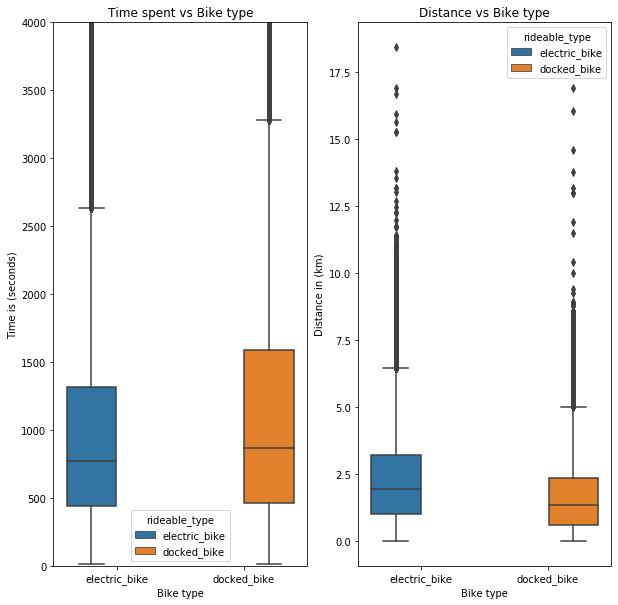

In [457]:
plt.figure(figsize = [10, 10])
plt.subplot(1,2,1)
sb.boxplot(data=df, y='time' , x='rideable_type', hue='rideable_type')
plt.ylim(0,4000) # There is extreme number of outliers so I hid them
plt.title("Time spent vs Bike type")
plt.ylabel("Time is (seconds)")
plt.xlabel("Bike type")
plt.subplot(1,2,2)
sb.boxplot(data=df, y='ride_distance', x='rideable_type', hue='rideable_type')
plt.title("Distance vs Bike type")
plt.ylabel("Distance in (km)")
plt.xlabel("Bike type")
plt.show()

Nice boxplot and have some interesting infomation.<br>
The `elecrtic_bike` spend less time than the `docked_bike` but in contrast travel for a longer distance

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


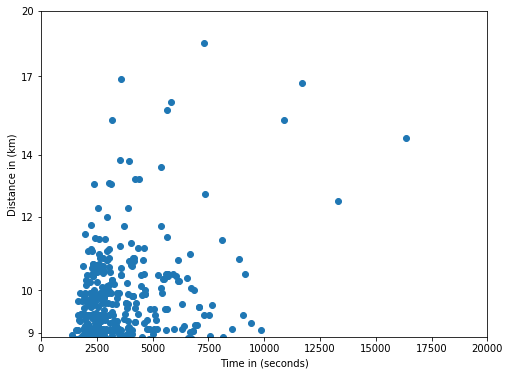

In [483]:
plt.figure(figsize = [8, 6])
plt.scatter(data = df, x = 'time', y = 'ride_distance')
plt.xlabel('Time in (seconds)')
plt.yscale('log')
plt.ylim(0,2e1)
plt.xlim(0, 2e4)
plt.yticks([9,10,12,14,17,20],[9,10,12,14,17,20])
plt.ylabel('Distance in (km)')
plt.show()

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> There is not many features to invastigate but I found that the Time and Distance are pretty interesting as they are numeric type and has some correlations

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> I see that Docked Bikes people use them for a longer time than the elecrtic ones but in contrast they use them for short distances

## Answers

By now, we have almost answered all our question:<br>
1. **When are most trips taken in terms of time of day, day of the week?**
  + By visualizing the data by boxplots and bar charts we can say that the most days that have rents are weekends 
  + Also, more rents happens afternoon and evening
2. **How long does the average trip take?**<br>
  The average trip takes about 1241 seconds (~ 20 minutes)
3. **Does the above depend on if a user is a subscriber or customer?**<br>
  Well, by grouping the data and splitting it we can conclude that - Yes, it depends on if a user is a member or customer in the time and distance
4. **What are the most interesting stations?**<br>
  The top 10 stations in N° of rents are:
  1. Market St at 10th St
  2. Hyde St at Post St
  3. Fell St at Stanyan St
  4. Powell St BART Station (Market St at 4th St)
  5. Mission Dolores Park
  6. 4th St at 16th St
  7. Market St at Dolores St
  8. Berry St at 4th St
  9. Sanchez St at 15th St
  10. Broderick St at Oak St<br>
And that may have many reasons; like the quality, disounts, N° of people in that region, etc...

$ $